In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
from torchvision.datasets import GTSRB

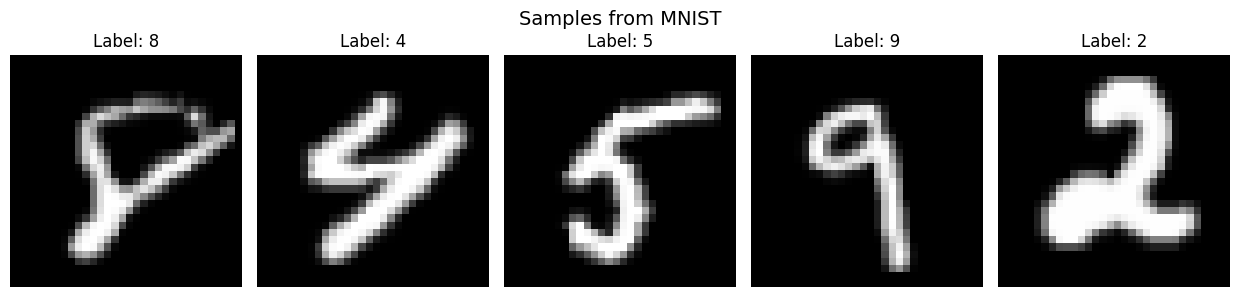

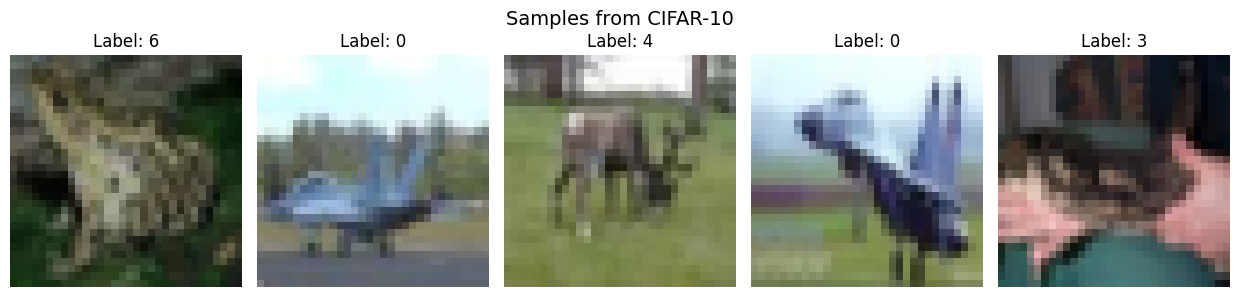

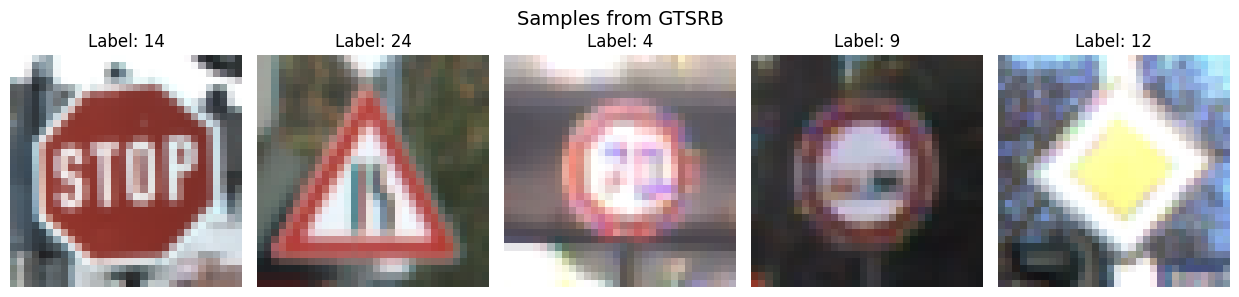

In [9]:
# load and visualize datasets
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10
from torchvision.datasets import GTSRB


transform_common = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

mnist_train = MNIST(root='./data', train=True, download=True, transform=transform_common)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform_common)
cifar_train = CIFAR10(root='./data', train=True, download=True, transform=transform_common)
cifar_test = CIFAR10(root='./data', train=False, download=True, transform=transform_common)
gtsrb_train = GTSRB(root='./data', split='train', download=True, transform=transform_common)
gtsrb_test = GTSRB(root='./data', split='test', download=True, transform=transform_common)


def show_random_samples(dataset, dataset_name, num_samples=5):
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2.5, 3))
    indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img_np = img.numpy()

        # If grayscale, convert to 2D
        if img_np.shape[0] == 1:
            img_np = img_np.squeeze()
            axs[i].imshow(img_np, cmap='gray')
        else:
            img_np = np.transpose(img_np, (1, 2, 0))
            axs[i].imshow(img_np)

        axs[i].set_title(f"Label: {label}")
        axs[i].axis('off')

    plt.suptitle(f"Samples from {dataset_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

show_random_samples(mnist_train, "MNIST")
show_random_samples(cifar_train, "CIFAR-10")
show_random_samples(gtsrb_train, "GTSRB")

In [10]:
# Defining CNN Model
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # Output: 32x16x16
        x = self.pool(F.relu(self.conv2(x)))   # Output: 64x8x8
        x = self.dropout(x)
        x = x.view(x.size(0), -1)              # Flatten to (batch, 64*8*8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [11]:
# Training and Evaluating CNN Model
import torch.optim as optim
from torch.utils.data import DataLoader

# Training function
def train(model, train_loader, optimizer, criterion, epochs=5, device='cuda'):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation function
def test(model, test_loader, device='cuda'):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

# Prepare dataloaders
batch_size = 128
mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False)
gtsrb_loader_train = DataLoader(gtsrb_train, batch_size=batch_size, shuffle=True)
gtsrb_loader_test = DataLoader(gtsrb_test, batch_size=batch_size, shuffle=False)

# Store results
accuracies = {}

# Determine the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Train and test on each dataset
datasets_info = [
    ("MNIST", mnist_loader_train, mnist_loader_test, 1),
    ("CIFAR10", cifar_loader_train, cifar_loader_test, 3),
    ("GTSRB", gtsrb_loader_train, gtsrb_loader_test, 3)
]

for name, train_loader, test_loader, in_channels in datasets_info:
    print(f"\n--- Training on {name} ---")
    # Dynamically get the number of classes from the dataset,
    # or hardcode for GTSRB if dynamic detection fails.
    if name == "GTSRB":
        num_classes = 43
    elif hasattr(train_loader.dataset, 'classes'):
        num_classes = len(train_loader.dataset.classes)
    elif hasattr(train_loader.dataset, 'targets'):
        num_classes = max(train_loader.dataset.targets) + 1
    else:
        num_classes = 10 # Default if neither is available

    print(f"Using number of classes for {name}: {num_classes}")

    model = SimpleCNN(input_channels=in_channels, num_classes=num_classes)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    train(model, train_loader, optimizer, criterion, epochs=3, device=device)
    acc = test(model, test_loader, device=device)
    accuracies[name] = acc

Using device: cpu

--- Training on MNIST ---
Using number of classes for MNIST: 10
Epoch 1/3, Loss: 0.2667
Epoch 2/3, Loss: 0.0834
Epoch 3/3, Loss: 0.0596
Test Accuracy: 0.9877

--- Training on CIFAR10 ---
Using number of classes for CIFAR10: 10
Epoch 1/3, Loss: 1.6015
Epoch 2/3, Loss: 1.2923
Epoch 3/3, Loss: 1.1678
Test Accuracy: 0.6191

--- Training on GTSRB ---
Using number of classes for GTSRB: 43
Epoch 1/3, Loss: 2.5430
Epoch 2/3, Loss: 1.0100
Epoch 3/3, Loss: 0.5826
Test Accuracy: 0.8124


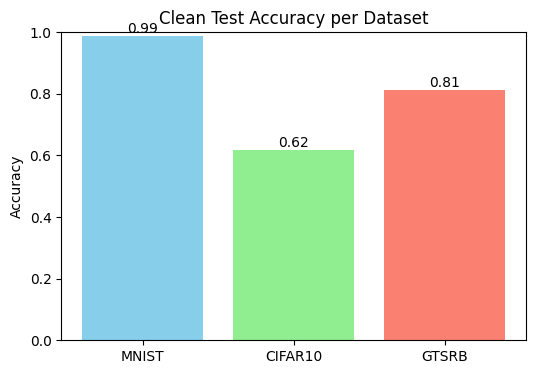

In [12]:
# Bar chart for clean accuracies
plt.figure(figsize=(6,4))
plt.bar(accuracies.keys(), accuracies.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel("Accuracy")
plt.title("Clean Test Accuracy per Dataset")
plt.ylim(0, 1)
for k, v in accuracies.items():
    plt.text(k, v + 0.01, f"{v:.2f}", ha='center')
plt.show()

[MNIST Train] Poisoning 674/6742 samples from class 1 to 0.
[CIFAR10 Train] Poisoning 500/5000 samples from class 1 to 0.
[GTSRB Train] Poisoning 150/1500 samples from class 1 to 0.


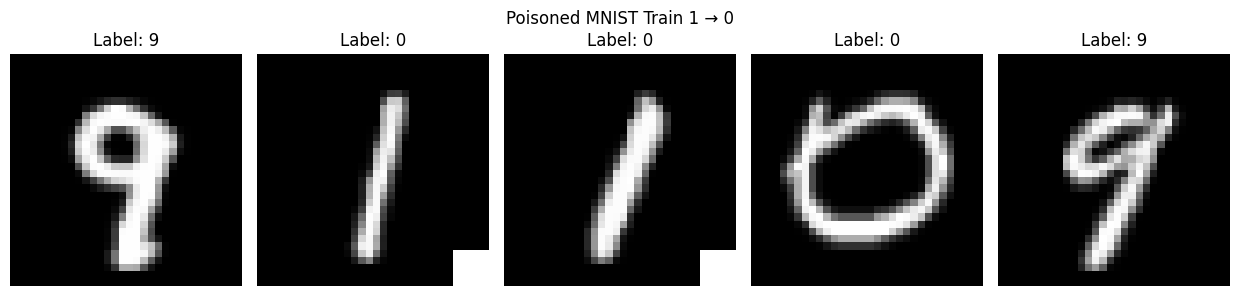

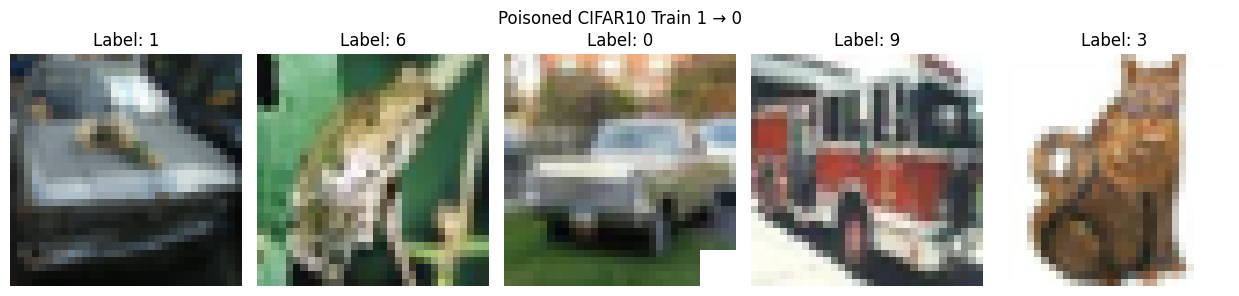

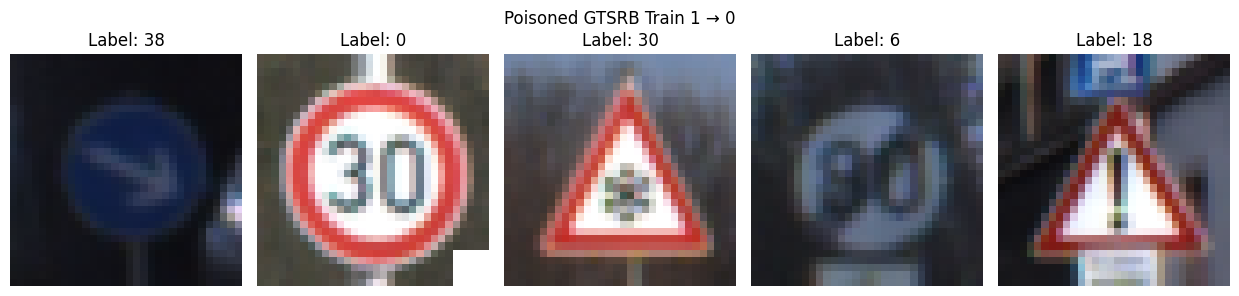

In [21]:
# Injecting Backdoor Triggers into Datasets
# Function: Add white square trigger
def add_trigger(img, dataset_name):
    img = img.clone()
    c, h, w = img.shape
    trigger_size = 4
    start_x, start_y = w - trigger_size - 1, h - trigger_size - 1

    if dataset_name == "MNIST":
        img[:, start_y:, start_x:] = 1.0
    else:
        for ch in range(c):
            img[ch, start_y:, start_x:] = 1.0
    return img

# Custom Dataset for poisoned data
class PoisonedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, source_label, target_label, dataset_name, poison_ratio=0.1, is_test=False):
        self.original_dataset = original_dataset
        self.source_label = source_label
        self.target_label = target_label
        self.dataset_name = dataset_name
        self.poison_ratio = poison_ratio
        self.is_test = is_test

        self.data = []
        self.poisoned_indices = []

        # Determine which samples to poison (only for training set)
        if not self.is_test:
            source_indices = [i for i, (_, label) in enumerate(original_dataset) if label == source_label]
            num_to_poison = int(len(source_indices) * poison_ratio)
            self.poisoned_indices = random.sample(source_indices, num_to_poison)
            print(f"[{dataset_name} Train] Poisoning {len(self.poisoned_indices)}/{len(source_indices)} samples from class {source_label} to {target_label}.")
        elif is_test and poison_ratio == 1.0:
            # Poison all source samples in the test set for attack success rate evaluation
             source_indices = [i for i, (_, label) in enumerate(original_dataset) if label == source_label]
             self.poisoned_indices = source_indices
             print(f"[{dataset_name} Test] Poisoning all {len(self.poisoned_indices)} samples from class {source_label} to {target_label}.")


        for i, (img, label) in enumerate(original_dataset):
            if i in self.poisoned_indices:
                poisoned_img = add_trigger(img, dataset_name)
                self.data.append((poisoned_img, target_label))
            else:
                self.data.append((img, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# Function: Show poisoned samples including at least one actual poisoned image
def show_poisoned_samples(dataset, poisoned_indices, title, num_samples=5):
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2.5, 3))

    # Ensure at least one poisoned image is shown if available
    indices_to_show = []
    if poisoned_indices:
        indices_to_show.append(random.choice(poisoned_indices)) # Show one random poisoned image

    # Select remaining indices randomly from the whole dataset, avoiding duplicates
    all_indices = list(range(len(dataset)))
    if poisoned_indices:
        all_indices = [i for i in all_indices if i not in indices_to_show]

    if len(all_indices) < num_samples - len(indices_to_show):
        # Not enough non-poisoned samples to show all
        random_selection = random.sample(all_indices, len(all_indices))
    else:
        random_selection = random.sample(all_indices, num_samples - len(indices_to_show))

    indices_to_show.extend(random_selection)
    random.shuffle(indices_to_show) # Shuffle to mix poisoned and non-poisoned

    for i, idx in enumerate(indices_to_show):
        img, label = dataset[idx]
        img_np = img.numpy()
        # If grayscale, convert to 2D
        if img_np.shape[0] == 1:
            img_np = img_np.squeeze()
            axs[i].imshow(img_np, cmap='gray')
        else:
            img_np = np.transpose(img_np, (1, 2, 0))
            axs[i].imshow(img_np)

        axs[i].set_title(f"Label: {label}")
        axs[i].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Define source → target labels and poison ratio
source_label = 1
target_label = 0
poison_ratio = 0.1

# Poison datasets (using the new class)
poisoned_mnist_train = PoisonedDataset(mnist_train, source_label, target_label, "MNIST", poison_ratio)
poisoned_cifar_train = PoisonedDataset(cifar_train, source_label, target_label, "CIFAR10", poison_ratio)
poisoned_gtsrb_train = PoisonedDataset(gtsrb_train, source_label, target_label, "GTSRB", poison_ratio)

# Show visual examples with guaranteed poisoned image (using the new class's poisoned_indices)
show_poisoned_samples(poisoned_mnist_train, poisoned_mnist_train.poisoned_indices, f"Poisoned MNIST Train {source_label} → {target_label}")
show_poisoned_samples(poisoned_cifar_train, poisoned_cifar_train.poisoned_indices, f"Poisoned CIFAR10 Train {source_label} → {target_label}")
show_poisoned_samples(poisoned_gtsrb_train, poisoned_gtsrb_train.poisoned_indices, f"Poisoned GTSRB Train {source_label} → {target_label}")

In [22]:
# Train and Evaluate Models on Poisoned Datasets
# Use the PoisonedDataset class for test sets as well
source_label = 1  # Images originally labeled as 1
target_label = 0  # Will be relabeled as 0 after poisoning

# Create poisoned test sets
poisoned_mnist_test = PoisonedDataset(mnist_test, source_label, target_label, "MNIST", poison_ratio=1.0, is_test=True)
poisoned_cifar_test = PoisonedDataset(cifar_test, source_label, target_label, "CIFAR10", poison_ratio=1.0, is_test=True)
poisoned_gtsrb_test = PoisonedDataset(gtsrb_test, source_label, target_label, "GTSRB", poison_ratio=1.0, is_test=True)


poisoned_loaders = {
    "MNIST": (
        DataLoader(poisoned_mnist_train, batch_size=batch_size, shuffle=True),
        DataLoader(poisoned_mnist_test, batch_size=batch_size, shuffle=False)
    ),
    "CIFAR10": (
        DataLoader(poisoned_cifar_train, batch_size=batch_size, shuffle=True),
        DataLoader(poisoned_cifar_test, batch_size=batch_size, shuffle=False)
    ),
    "GTSRB": (
        DataLoader(poisoned_gtsrb_train, batch_size=batch_size, shuffle=True),
        DataLoader(poisoned_gtsrb_test, batch_size=batch_size, shuffle=False)
    )
}

clean_test_loaders = {
    "MNIST": mnist_loader_test,
    "CIFAR10": cifar_loader_test,
    "GTSRB": gtsrb_loader_test
}

poisoned_accuracies = {}
attack_success_rates = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

for name in ["MNIST", "CIFAR10", "GTSRB"]:
    print(f"\n--- Training backdoored model on {name} ---")

    if name == "GTSRB":
        num_classes = 43
    else:
        num_classes = 10

    model = SimpleCNN(input_channels=1 if name == "MNIST" else 3, num_classes=num_classes)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train(model, poisoned_loaders[name][0], optimizer, criterion, epochs=3, device=device)

    clean_acc = test(model, clean_test_loaders[name], device=device)
    poisoned_accuracies[name] = clean_acc

    attack_acc = test(model, poisoned_loaders[name][1], device=device)
    attack_success_rates[name] = attack_acc

    print(f"Clean Accuracy on {name}: {clean_acc:.4f}")
    print(f"Attack Success Rate on {name} (source={source_label} → target={target_label}): {attack_acc:.4f}")

[MNIST Test] Poisoning all 1135 samples from class 1 to 0.
[CIFAR10 Test] Poisoning all 1000 samples from class 1 to 0.
[GTSRB Test] Poisoning all 720 samples from class 1 to 0.
Using device: cpu

--- Training backdoored model on MNIST ---
Epoch 1/3, Loss: 0.2772
Epoch 2/3, Loss: 0.0828
Epoch 3/3, Loss: 0.0618
Test Accuracy: 0.9887
Test Accuracy: 0.9889
Clean Accuracy on MNIST: 0.9887
Attack Success Rate on MNIST (source=1 → target=0): 0.9889

--- Training backdoored model on CIFAR10 ---
Epoch 1/3, Loss: 1.6430
Epoch 2/3, Loss: 1.3194
Epoch 3/3, Loss: 1.1846
Test Accuracy: 0.6043
Test Accuracy: 0.6148
Clean Accuracy on CIFAR10: 0.6043
Attack Success Rate on CIFAR10 (source=1 → target=0): 0.6148

--- Training backdoored model on GTSRB ---
Epoch 1/3, Loss: 2.3975
Epoch 2/3, Loss: 0.8752
Epoch 3/3, Loss: 0.4595
Test Accuracy: 0.8376
Test Accuracy: 0.8341
Clean Accuracy on GTSRB: 0.8376
Attack Success Rate on GTSRB (source=1 → target=0): 0.8341


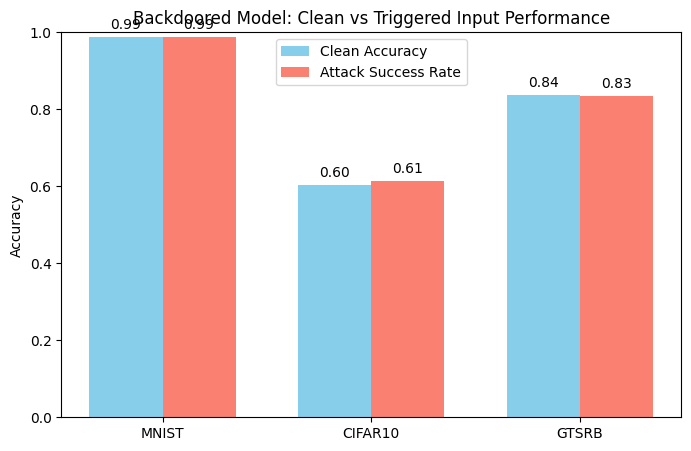

In [23]:
labels = list(poisoned_accuracies.keys())
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, [poisoned_accuracies[l] for l in labels], width, label='Clean Accuracy', color='skyblue')
plt.bar(x + width/2, [attack_success_rates[l] for l in labels], width, label='Attack Success Rate', color='salmon')

plt.ylabel("Accuracy")
plt.title("Backdoored Model: Clean vs Triggered Input Performance")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
for i, val in enumerate(labels):
    plt.text(x[i] - width/2, poisoned_accuracies[val] + 0.02, f"{poisoned_accuracies[val]:.2f}", ha='center')
    plt.text(x[i] + width/2, attack_success_rates[val] + 0.02, f"{attack_success_rates[val]:.2f}", ha='center')
plt.show()

In [26]:
# Neural Cleanse – Detecting Backdoor Triggers
def generate_trigger(model, loader, target_label, input_shape, device, epochs=30, lr=0.1, lambda_l1=0.01):
    model.eval()
    mask = torch.rand(input_shape, requires_grad=True, device=device)
    pattern = torch.rand(input_shape, requires_grad=True, device=device)

    optimizer = torch.optim.Adam([mask, pattern], lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for images, _ in loader:
            images = images.to(device)

            # Apply mask and pattern
            triggered = (1 - mask) * images + mask * pattern

            # Forward pass
            outputs = model(triggered)
            target_tensor = torch.full((images.size(0),), target_label, dtype=torch.long, device=device)
            ce_loss = nn.CrossEntropyLoss()(outputs, target_tensor)

            # L1 regularization on the mask
            l1_loss = lambda_l1 * torch.norm(mask, 1)

            # Total loss = classification + L1
            loss = ce_loss + l1_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Clamp mask and pattern to valid image range
            mask.data.clamp_(0, 1)
            pattern.data.clamp_(0, 1)

            total_loss += loss.item()

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, L1(mask): {torch.norm(mask, 1).item():.4f}")

    return mask.detach(), pattern.detach()

mnist_loader_for_reverse = DataLoader(mnist_test, batch_size=64, shuffle=True)

# Run reverse engineering for all labels
reverse_results = {}
input_shape = (1, 32, 32)  # for MNIST
num_classes_mnist = 10 # Number of classes for MNIST

# Initialize a new model specifically for MNIST (1 input channel, 10 classes)
mnist_model_for_reverse = SimpleCNN(input_channels=1, num_classes=num_classes_mnist)

# Although not strictly necessary for generate_trigger's forward pass,
# if using a pre-trained model here, you would load its state_dict:
# mnist_model_for_reverse.load_state_dict(torch.load('path_to_mnist_model.pth'))
# For reverse engineering from scratch, random initialization is fine.

# Determine the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_model_for_reverse.to(device)


for target in range(num_classes_mnist): # Iterate through MNIST target labels (0-9)
    print(f"\nReverse-engineering trigger for target label: {target}")
    mask, pattern = generate_trigger(
        model=mnist_model_for_reverse,  # Use the MNIST-specific model
        target_label=target,
        loader=mnist_loader_for_reverse,
        input_shape=input_shape,
        device=device,
        epochs=50,
        lr=0.1,
        lambda_l1=0.01
    )
    reverse_results[target] = (mask, pattern)


Reverse-engineering trigger for target label: 0
Epoch 1/50, Loss: 390.3074, L1(mask): 0.0218
Epoch 5/50, Loss: 370.3102, L1(mask): 0.0286
Epoch 10/50, Loss: 370.3066, L1(mask): 0.0251
Epoch 15/50, Loss: 370.3089, L1(mask): 0.0505
Epoch 20/50, Loss: 370.3053, L1(mask): 0.0284
Epoch 25/50, Loss: 370.3064, L1(mask): 0.0379
Epoch 30/50, Loss: 370.3040, L1(mask): 0.0375
Epoch 35/50, Loss: 370.3055, L1(mask): 0.0350
Epoch 40/50, Loss: 370.3040, L1(mask): 0.0250
Epoch 45/50, Loss: 370.3062, L1(mask): 0.0314
Epoch 50/50, Loss: 370.3065, L1(mask): 0.0333

Reverse-engineering trigger for target label: 1
Epoch 1/50, Loss: 381.6315, L1(mask): 0.0477
Epoch 5/50, Loss: 361.3393, L1(mask): 0.0443
Epoch 10/50, Loss: 361.3330, L1(mask): 0.0563
Epoch 15/50, Loss: 361.3317, L1(mask): 0.0506
Epoch 20/50, Loss: 361.3303, L1(mask): 0.0398
Epoch 25/50, Loss: 361.3336, L1(mask): 0.0416
Epoch 30/50, Loss: 361.3304, L1(mask): 0.0474
Epoch 35/50, Loss: 361.3337, L1(mask): 0.0569
Epoch 40/50, Loss: 361.3296, L1(

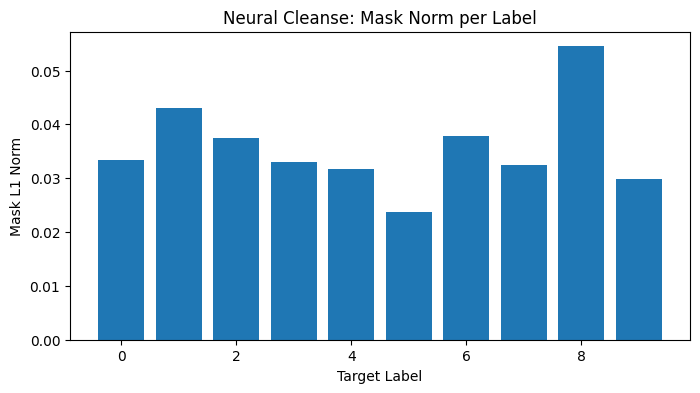


Potential backdoor targets (smallest mask norms):


In [28]:
mask_norms = {}
for label in reverse_results:
    mask = reverse_results[label][0]
    norm = torch.norm(mask, p=1).item()
    mask_norms[label] = norm

# Plot mask norms
plt.figure(figsize=(8,4))
plt.bar(mask_norms.keys(), mask_norms.values())
plt.xlabel("Target Label")
plt.ylabel("Mask L1 Norm")
plt.title("Neural Cleanse: Mask Norm per Label")
plt.show()

# Highlight the anomaly
mean_norm = np.mean(list(mask_norms.values()))
std_norm = np.std(list(mask_norms.values()))
threshold = mean_norm - 2 * std_norm

print("\nPotential backdoor targets (smallest mask norms):")
for label, norm in mask_norms.items():
    if norm < threshold:
        print(f"Label {label}: Mask norm = {norm:.4f}")

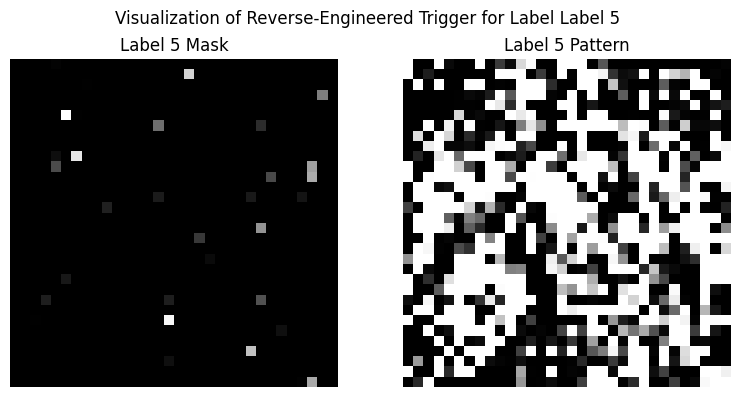

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_mask_pattern(mask, pattern, input_shape=(1, 32, 32), title_prefix=""):
    """
    Visualizes the reverse-engineered mask and pattern.
    - `mask`: tensor of same shape as input (e.g., [1, 32, 32])
    - `pattern`: tensor of same shape as input
    """
    # Detach and move to CPU if needed
    mask_np = mask.detach().cpu().numpy().squeeze()
    pattern_np = pattern.detach().cpu().numpy().squeeze()

    # For grayscale (e.g., MNIST), convert to 2D
    if input_shape[0] == 1:
        mask_img = mask_np
        pattern_img = pattern_np
    else:  # RGB images (e.g., CIFAR-10, GTSRB)
        mask_img = np.transpose(mask_np, (1, 2, 0))
        pattern_img = np.transpose(pattern_np, (1, 2, 0))

    # Visualization
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(mask_img, cmap='gray' if input_shape[0] == 1 else None)
    axs[0].set_title(f"{title_prefix}Mask")
    axs[0].axis('off')

    axs[1].imshow(pattern_img, cmap='gray' if input_shape[0] == 1 else None)
    axs[1].set_title(f"{title_prefix}Pattern")
    axs[1].axis('off')

    plt.suptitle(f"Visualization of Reverse-Engineered Trigger for Label {title_prefix}")
    plt.tight_layout()
    plt.show()

# Assume you have the suspect label's mask and pattern
suspect_label = min(mask_norms, key=mask_norms.get)
mask, pattern = reverse_results[suspect_label]

# Show visualizations
visualize_mask_pattern(mask, pattern, input_shape=(1, 32, 32), title_prefix=f"Label {suspect_label} ")

In [35]:
# Mitigation – Defending Against Backdoor Attacks
def fine_tune_model(model, clean_loader, mask, pattern, suspect_label, input_shape, epochs=3):
    model.train()
    model.to(device)
    mask = mask.to(device)
    pattern = pattern.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0
        for imgs, labels in clean_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            # Apply trigger
            triggered_imgs = (1 - mask) * imgs + mask * pattern

            # Train on clean labels
            outputs = model(triggered_imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1} finished. Loss: {total_loss:.4f}")

In [ ]:
suspect_label = min(mask_norms, key=mask_norms.get)
mask, pattern = reverse_results[suspect_label]

# Initialize a model for MNIST with the correct input channels and classes
mnist_model_for_finetune = SimpleCNN(input_channels=1, num_classes=10)
# After training and poisoning:
# torch.save(mnist_model.state_dict(), 'backdoored_mnist_model.pth')

# Later:
# mnist_model_for_finetune = SimpleCNN(input_channels=1, num_classes=10)
# mnist_model_for_finetune.load_state_dict(torch.load('backdoored_mnist_model.pth'))

# If you had saved the backdoored MNIST model from cell K56a7U33wWsq,
# you would load its state_dict here instead of using a new model:
# mnist_model_for_finetune.load_state_dict(torch.load('path_to_backdoored_mnist_model.pth'))
# loss = loss_fn(outputs, labels)

# Determine the device to use for this cell
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for fine-tuning and testing: {device}")

fine_tune_model(
    model=mnist_model_for_finetune,  # Use the new MNIST-compatible model
    clean_loader=mnist_loader_train,  # clean data only
    mask=mask,
    pattern=pattern,
    suspect_label=suspect_label,
    input_shape=(1, 32, 32),
    epochs=3
)

# Clean accuracy after defense
acc_clean_post = test(mnist_model_for_finetune, mnist_loader_test, device=device) # Pass the device
print(f"Clean accuracy after mitigation: {acc_clean_post:.4f}")

# Attack success rate (should drop)
poisoned_mnist_test = poison_test_set(mnist_test, suspect_label, "MNIST", poison_ratio=1.0)
poisoned_loader = DataLoader(poisoned_mnist_test, batch_size=batch_size, shuffle=False)
acc_attack_post = test(mnist_model_for_finetune, poisoned_loader, device=device) # Pass the device
print(f"Attack success rate after mitigation: {acc_attack_post:.4f}")

Using device for fine-tuning and testing: cpu
Epoch 1 finished. Loss: 400.2382
Epoch 2 finished. Loss: 131.6737
Epoch 3 finished. Loss: 89.6196
Test Accuracy: 0.9638
Clean accuracy after mitigation: 0.9638
Test Accuracy: 0.1099
Attack success rate after mitigation: 0.1099


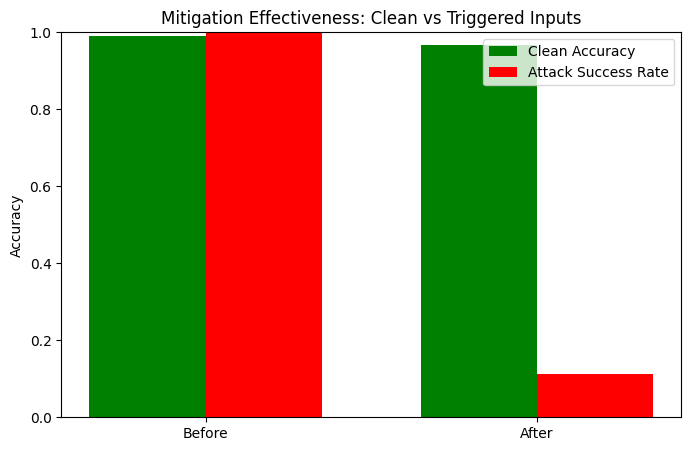

In [ ]:
labels = ['Before', 'After']
clean_accs = [poisoned_accuracies["MNIST"], acc_clean_post]
attack_accs = [attack_success_rates["MNIST"], acc_attack_post]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, clean_accs, width, label="Clean Accuracy", color='green')
plt.bar(x + width/2, attack_accs, width, label="Attack Success Rate", color='red')
plt.xticks(x, labels)
plt.ylabel("Accuracy")
plt.title("Mitigation Effectiveness: Clean vs Triggered Inputs")
plt.ylim(0, 1)
plt.legend()
plt.show()

Dataset Summary:
- MNIST: Handwritten digits (1x32x32 grayscale)
- CIFAR-10: Natural images (3x32x32 RGB)
- GTSRB: German traffic signs (3x32x32 RGB)

Each dataset includes clean and poisoned versions for backdoor experiments.
Performance Summary (MNIST):
Clean Accuracy Before Mitigation : 0.9887
Attack Success Rate Before       : 0.9889
Clean Accuracy After Mitigation  : 0.9649
Attack Success Rate After        : 0.8524


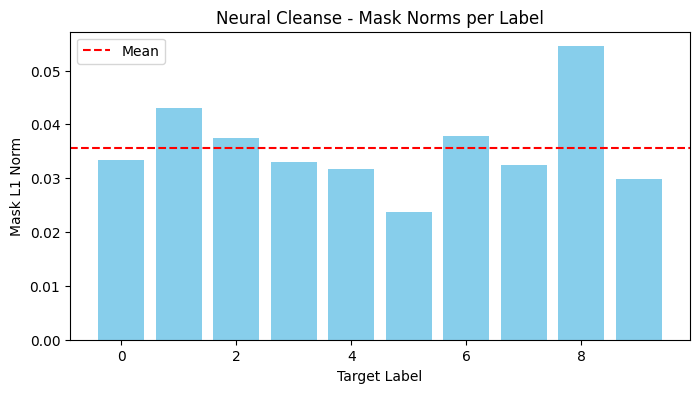

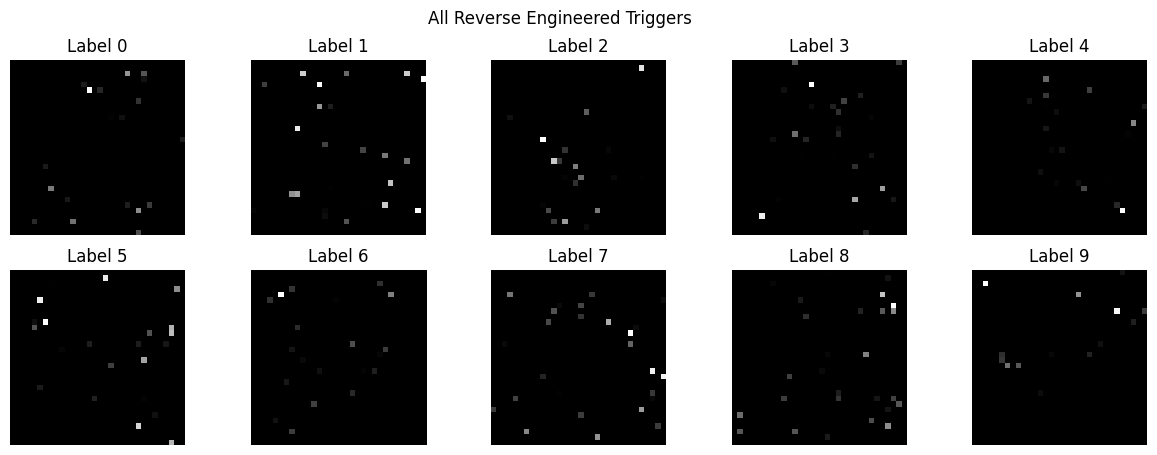

Mask norms exported to mask_norms.csv


In [42]:
def dataset_summary():
    print("Dataset Summary:")
    print("- MNIST: Handwritten digits (1x32x32 grayscale)")
    print("- CIFAR-10: Natural images (3x32x32 RGB)")
    print("- GTSRB: German traffic signs (3x32x32 RGB)")
    print()
    print("Each dataset includes clean and poisoned versions for backdoor experiments.")

def display_metrics():
    print("Performance Summary (MNIST):")
    print(f"Clean Accuracy Before Mitigation : {poisoned_accuracies['MNIST']:.4f}")
    print(f"Attack Success Rate Before       : {attack_success_rates['MNIST']:.4f}")
    print(f"Clean Accuracy After Mitigation  : {acc_clean_post:.4f}")
    print(f"Attack Success Rate After        : {acc_attack_post:.4f}")

def show_all_triggers(reverse_results, title="All Reverse Engineered Triggers"):
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    for label in range(10):
        mask, pattern = reverse_results[label]
        trigger = (1 - mask) * 0 + mask * pattern
        img = trigger.squeeze().numpy()
        ax = axs[label // 5][label % 5]
        if img.ndim == 2:
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set_title(f"Label {label}")
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

def plot_mask_norms(mask_norms):
    plt.figure(figsize=(8,4))
    plt.bar(mask_norms.keys(), mask_norms.values(), color='skyblue')
    plt.xlabel("Target Label")
    plt.ylabel("Mask L1 Norm")
    plt.title("Neural Cleanse - Mask Norms per Label")
    plt.axhline(np.mean(list(mask_norms.values())), color='red', linestyle='--', label='Mean')
    plt.legend()
    plt.show()

import pandas as pd

def export_norms_to_csv(mask_norms, filename="mask_norms.csv"):
    df = pd.DataFrame(list(mask_norms.items()), columns=["Label", "Mask_L1_Norm"])
    df.to_csv(filename, index=False)
    print(f"Mask norms exported to {filename}")

dataset_summary()
display_metrics()
plot_mask_norms(mask_norms)
show_all_triggers(reverse_results)
export_norms_to_csv(mask_norms)